In [ ]:
# basic imports
import pandas as pd
import numpy as np
from collections import defaultdict

# display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# ml imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC, SVC
from photonai.base import Hyperpipe, PipelineElement,  Stack
from photonai.optimization import FloatRange, Categorical, IntegerRange
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


# model selection
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from tune_sklearn import TuneSearchCV

# metrics
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from boruta import BorutaPy

# view plotly in jupyter 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [61]:
df = pd.read_csv('../data/final_csv.csv')

#### Model Building -- will a company fail or succeed

In [62]:
df.status = df.status.map({0: 'fail', 1: 'succeed', 2: 'succeed', 3: 'succeed'})

In [63]:
cat_dict = dict(df.category_list.value_counts() == 1)
single_cat = [k for k, v in cat_dict.items() if v == True]
df.category_list = df.category_list.apply(lambda x: 'unique_company' if x in (single_cat) else x)
df.top_univ_in_city = df.top_univ_in_city.map({True:1, False:0})



In [64]:
y = df.status
X = df.drop(['status', 'category_list', 'funding_total_usd', 'state_code', 'region',
            'city', 'funding_rounds', 'founded_at', 'first_funding_at', 'last_funding_at',
            'first_last_funding', 'unique_industry_names_in_city', 'zip', 'lat', 'long', 'ratio_fail_by_region'], axis=1)

In [ ]:
# VIF_selection = df.drop(['category_list', 'state_code', 'region', 'city', 'status', 'funding_total_usd'], axis=1)

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

calculate_vif_(X)

In [65]:
X = df[['category_list','average_funding', 'len_of_company_name', 'len_of_company_url', 'num_of_company_cat', 'first_funding_total_per_region', 'avg_first_funding_per_region', 'city_count', 'first_funding_total_per_state_code', 'avg_first_funding_per_state_code', 'population_by_state', 'pop_per_city', 'pop_density_per_city', 'top_univ_in_city', 'num_top_univ_per_state']]
X = pd.get_dummies(X, drop_first=True)
X_cols = X.columns.tolist()

scaler = MinMaxScaler(feature_range = (0,1))
X = scaler.fit_transform(X)
X = pd.DataFrame(data=X, columns = X_cols)

sm = SMOTE(random_state=2)
X, y = sm.fit_resample(X, y)
y = y.map({'succeed': 1, 'fail': 0})

In [ ]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
boruta = BorutaPy(rf, n_estimators='auto', random_state=4242, max_iter= 50, perc=90)

boruta.fit(np.array(X), np.array(y))

In [ ]:
strong_features = X.columns[boruta.support_].to_list()
weak_features = X.columns[boruta.support_weak_].to_list()

In [66]:
weak_features = ['category_list_crowdsourcing',
 'category_list_design',
 'category_list_groceries',
 'category_list_parenting',
 'category_list_semiconductors']

In [67]:
X = X.drop(weak_features, axis=1)

#### Dummy Model

In [68]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
DummyClassifier(strategy='most_frequent')
y_pred = dummy_clf.predict(X)
dummy_clf.score(X, y)

0.5

In [69]:
def metric_display(y, y_pred):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    cf_matrix = confusion_matrix(y, y_pred)

    labels = ['True Neg','False Pos','False Neg','True Pos']
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
                fmt='.2%', cmap='Blues', ax=axes[0])

    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', ax=axes[1])

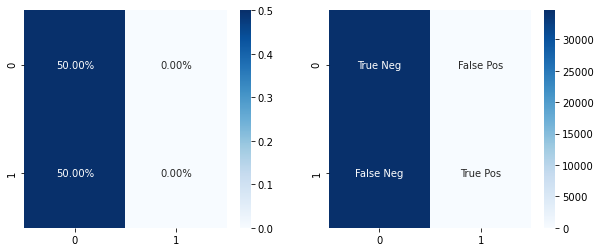

In [70]:
fig = metric_display(y, y_pred)
fig

#### What score measure should our models emphasize? 
Accuracy is important, but I am selecting recall as the most important metric as a False Positive in our case, is a business has been identified as a failiure, but it actually has a higher chance to succeed. This is a most investment oprotunity, but no money is lost. For our False Negative, we identified a business as one that would succeed, but it turns out it is more likely to fail. This would more likely cause a loss. As a mixture of recall and accuracy, F1 score can be used.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X, y = shuffle(X, y, random_state=42)

In [ ]:
models = [RidgeClassifier(), RandomForestClassifier(), xgb.XGBClassifier()]

k_fold = KFold(n_splits=10, shuffle=True)

model_score_dict = defaultdict(list)

for model in models:
    
    model = model
    
    accuracy_lst = []
    precision_lst = []
    recall_lst = []
    balanced_accuracy = []
    
    for train_i, test_i in k_fold.split(X_train):
        model.fit(X_train.values[train_i],
                  y_train.values[train_i])
        y_pred = model.predict(X_train.values[test_i])
        
        accuracy_lst.append(accuracy_score(y_train.values[test_i], y_pred))
        precision_lst.append(precision_score(y_train.values[test_i], y_pred))
        recall_lst.append(recall_score(y_train.values[test_i], y_pred))
        balanced_accuracy.append(balanced_accuracy_score(y_train.values[test_i], y_pred))
    
    
    acc_mean = np.mean(accuracy_lst)
    pre_mean = np.mean(precision_lst)
    rec_mean = np.mean(recall_lst)
    bal_mean = np.mean(balanced_accuracy)
    
    model_score_dict[model].append(acc_mean)
    model_score_dict[model].append(pre_mean)
    model_score_dict[model].append(rec_mean)
    model_score_dict[model].append(bal_mean)
    

In [ ]:
model_df = pd.DataFrame(model_score_dict)
model_df.index = ['accuracy', 'precision', 'recall', 'balanced_accuracy']

In [ ]:
model_df

#### Baseline LogisticRegression

0.6515979586666184


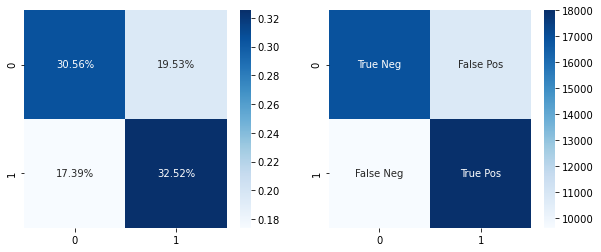

In [72]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(recall_score(y_train, y_pred))

fig = metric_display(y_train, y_pred)

#### Hyperparam Tuning Logistic Regression
Model is selected due to coef interpretability

In [ ]:
lr = LogisticRegression()
params_lr = {'penalty':['l1', 'l2'], 'C': np.logspace(-4, 4, 20).tolist(), 'n_jobs':[-1], 'solver': ['liblinear']}

lr_tunesearch = TuneSearchCV(lr, params_lr, n_trials=5, use_gpu=True, scoring='recall')
lr_tunesearch.fit(X_train, y_train)

lr_best = lr_tunesearch.best_estimator_
print(lr_tunesearch.best_params_)

In [ ]:
lr_optimal_params = [penalty='l1', C=0.03359818286283781, solver='liblinear']

0.7358978039328262


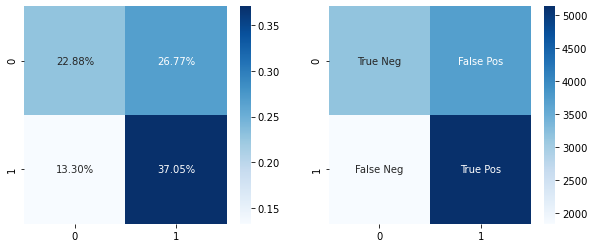

In [73]:
optimal_lr = LogisticRegression(penalty='l1', C=0.03359818286283781, solver='liblinear')
optimal_lr.fit(X_train, y_train)
y_pred = optimal_lr.predict(X_test)
print(recall_score(y_test, y_pred))

metric_display(y_test, y_pred)

In [ ]:
# observing the top 10 coef
odds = np.exp(optimal_lr.coef_[0])
coef_df = pd.DataFrame(odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)


'''
For every one-unit increase in [X variable],
the odds that the observation is in (y class) are [coefficient] times as large 
as the odds that the observation is not in (y class) when all other variables are held constant
'''

# For every one percent increase in the ratio of success in a region, the odds that the a company will succeed are roughly 4 times as large
# as the odds that the company will not succeed when all other variables are held constant.

coef_df = coef_df.iloc[:15, :]

In [ ]:
fig = px.bar(coef_df, x='coef')

fig.update_layout(
    xaxis_title_text='Size of Coefficient',
    yaxis_title_text='Features',
    bargap=0.2, showlegend=True,
    title_text='Top 15 Coefficients for Logistic Regression',
    title_x=0.5,
)
# fig.write_image("../image s/lr_coef.png")
fig.show();

#### Find Optimal Random Forest Hyperparams for Recall and Balanced Accuracy

In [ ]:
rf = RandomForestClassifier()
params_rf = {'n_estimators': [50, 100, 200], 'max_features':['auto', 'sqrt'], 'max_depth':[int(x) for x in np.linspace(10, 110, num = 11)], 'min_samples_split': [2, 5, 10]}

rf_tunesearch = TuneSearchCV(rf, params_rf, cv=3, verbose=1, use_gpu=True, scoring='balanced_accuracy')
rf_tunesearch.fit(X_train, y_train)

rf_best = rf_tunesearch.best_estimator_
print(rf_tunesearch.best_params_)

In [ ]:
balanced_forest_optimal_params = {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 70, 'min_samples_split': 2}
recall_forest_optimal_params = {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 90, 'min_samples_split': 5}

##### Create optimal Random Forest Models for Recall and Balanced Accuracy

In [ ]:
optimal_balanced_rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=70, min_samples_split=2)
optimal_balanced_rf.fit(X_train, y_train)
y_pred = optimal_balanced_rf.predict(X_test)

print(recall_score(y_test, y_pred))
metric_display(y_test, y_pred)

In [ ]:
optimal_recall_rf = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=90, min_samples_split=5)
optimal_recall_rf.fit(X_train, y_train)
y_pred = optimal_recall_rf.predict(X_test)

print(recall_score(y_test, y_pred))
metric_display(y_test, y_pred)

#### Ensemble Models

In [ ]:

estimators=[('rf_recall', optimal_recall_rf), ('lr', optimal_lr), ('rf_balanced', optimal_balanced_rf)]

ensemble = VotingClassifier(estimators, voting='hard')

In [ ]:
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)


print(recall_score(y_test, y_pred))

metric_display(y_test, y_pred)

In [ ]:
pca = PCA()

lr = LogisticRegression()

pipe = Pipeline(steps=[('pca', pca),
                       ('logistic_reg', lr)])

n_components = list(range(1, 50))
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']

parameters = dict(pca__n_components=n_components,
                      logistic_reg__C=C,
                      logistic_reg__penalty=penalty)

#### optimizing Logistic Regression with PCA

In [ ]:
lr_gridsearch = GridSearchCV(pipe, parameters, scoring='recall', n_jobs=-1)
lr_gridsearch.fit(X, y)

In [ ]:
print('Best Penalty:', lr_gridsearch.best_estimator_.get_params()['logistic_reg__penalty'])
print('Best C:', lr_gridsearch.best_estimator_.get_params()['logistic_reg__C'])
print('Best Number Of Components:', lr_gridsearch.best_estimator_.get_params()['pca__n_components'])
print(); print(lr_gridsearch.best_estimator_.get_params()['logistic_reg'])

In [ ]:
'''Best gridsearch with pca: GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('logistic_reg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logistic_reg__C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02,...
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'logistic_reg__penalty': ['l1', 'l2'],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19, 20, 21, 22, 23, 24, 25, 26,
                                               27, 28, 29, 30, ...]},
             scoring='recall')
             
             
Best Penalty: l2
Best C: 0.3906939937054613
Best Number Of Components: 45

LogisticRegression(C=0.3906939937054613)'''    

In [ ]:
pca = PCA(n_components=45)

lr = LogisticRegression(penalty='l2', C=0.3906939937054613)

pipe = Pipeline(steps=[('pca', pca),
                       ('logistic_reg', lr)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print(recall_score(y_test, y_pred))

metric_display(y_test, y_pred)

#### Random Forest model interpretation

0.9745945170087555


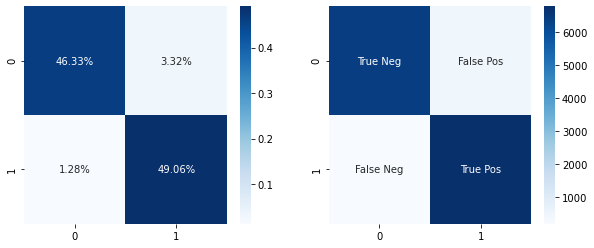

In [74]:
optimal_recall_rf = RandomForestClassifier(n_estimators=200, max_features='sqrt', n_jobs=-1, max_depth=90, min_samples_split=5)
optimal_recall_rf.fit(X_train, y_train)
y_pred = optimal_recall_rf.predict(X_test)

print(recall_score(y_test, y_pred))
metric_display(y_test, y_pred)

Text(0, 0.5, 'FEATURE NAMES')

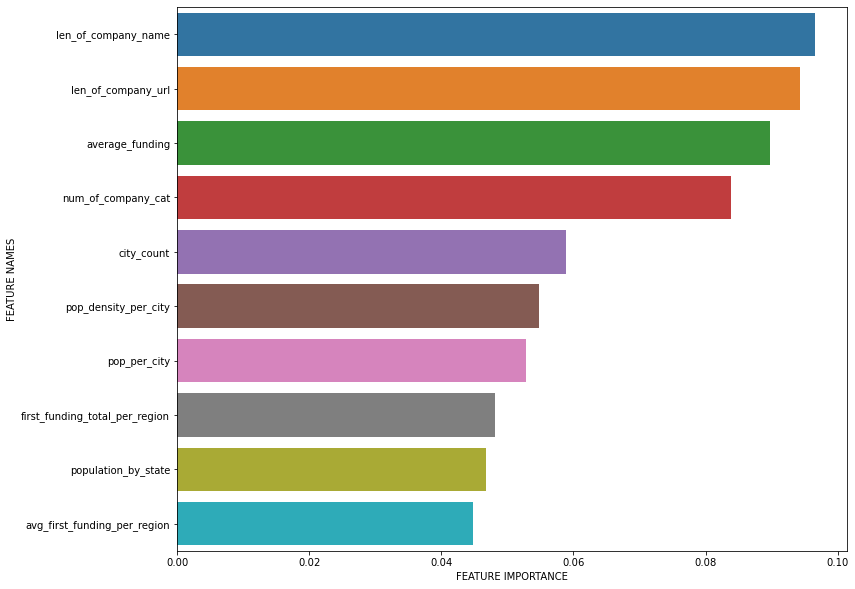

In [75]:
optimal_recall_rf.feature_importances_

features = X.columns.tolist()
importances = optimal_recall_rf.feature_importances_
indices = np.argsort(importances)[:15]


feature_importance = optimal_recall_rf.feature_importances_
feature_names = X.columns.tolist()


data={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)

fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi_df = fi_df.iloc[:10, :]


plt.figure(figsize=(12,10))
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')
# plt.savefig('../images/feature_importance_rf')